In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from surprise import SVD, Dataset, Reader

### Load data

In [22]:
df = pd.read_csv("../data/data_cleaned.csv", low_memory=False)
df.head()

,Runner ID,First Name,Surname,Nat.,Gender,Age,Age Group,Cat,YOB,Race Count,...,Cat. Rank,Finish Percentage,Performance Ratio,Distance/Time,Distance KM,Terrain,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
0,146799,David,Papineau,CAN,M,42.0,40-49,M40,1968.0,0,...,1.0,0.02,1.000000,50km,50.0,road,13911.0,NaN,278.22,12.939
1,35382,Hassan,Lotfi-Pour,CAN,M,42.0,40-49,M40,1968.0,0,...,2.0,0.04,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
2,11991,Ryne,Melcher,CAN,M,31.0,30-39,M23,1979.0,0,...,1.0,0.05,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
3,37142,Gary,Robbins,CAN,M,34.0,30-39,M23,1976.0,0,...,2.0,0.07,0.966377,50km,50.0,road,14395.0,NaN,287.90,12.504
4,746071,Rian,O'Maol Chonaire,CAN,M,33.0,30-39,M23,1977.0,0,...,3.0,0.09,0.920040,50km,50.0,road,15120.0,NaN,302.40,11.905


In [23]:
df_clean = df[df['Event Type']=='Distance']

In [24]:
df_clean.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'Gender', 'Age',
       'Age Group', 'Cat', 'YOB', 'Race Count', 'Cumulative Distance KM',
       'Event ID', 'Event', 'Event Type', 'Date', 'Race Location',
       'Elevation Gain', 'Elevation Gain per KM', 'Total Finishers',
       'Male Finishers', 'Female Finishers', 'Time Seconds Winner',
       'Distance Winner', 'Rank', 'Rank M/F', 'Cat. Rank', 'Finish Percentage',
       'Performance Ratio', 'Distance/Time', 'Distance KM', 'Terrain',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h'],
      dtype='object')

### Race difficulty weighting

In [25]:
def aggregate_by_event(df):
    agg_data = df.groupby('Event ID').agg({
        'Distance KM': 'first',
        'Elevation Gain': 'first',
        'Terrain': 'first',
        'Total Finishers': 'first',
        'Time Seconds Winner': 'first',
        'Time Seconds Finish': 'mean'
    }).reset_index()
    
    # Calculate average time
    agg_data['Average Time Seconds'] = agg_data['Time Seconds Finish']
    
    # Calculate winner and average pace
    agg_data['Winner Pace'] = agg_data['Time Seconds Winner'] / 60 / agg_data['Distance KM']
    agg_data['Average Pace'] = agg_data['Average Time Seconds'] / 60 / agg_data['Distance KM']
    
    return agg_data

# Apply aggregation
df_event = aggregate_by_event(df_clean)

In [8]:
def sigmoid_normalize(x, midpoint, steepness=1):
    return 1 / (1 + np.exp(-steepness * (x - midpoint)))

def calculate_race_difficulty(df, weights):
    # Normalize factors
    distance_factor = sigmoid_normalize(df['Distance KM'], midpoint=100, steepness=0.05)
    elevation_factor = sigmoid_normalize(df['Elevation Gain'], midpoint=2500, steepness=0.001)
    terrain_factor = {'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5}[df['Terrain']]
    finishers_factor = max(1 - (df['Total Finishers'] / 1000), 0.5)
    
    # Calculate difficulty score using provided weights
    difficulty_score = (
        distance_factor * weights['distance'] +
        elevation_factor * weights['elevation'] +
        terrain_factor * weights['terrain'] +
        finishers_factor * weights['finishers']
    )
    
    return difficulty_score


In [27]:
weights = {
    'distance': 0.4,
    'elevation': 0.3,
    'terrain': 0.2,
    'finishers': 0.1
}

df_event['Race Difficulty Score'] = df_event.apply(calculate_race_difficulty, weights=weights, axis=1)

In [28]:
df_event.head()

,Event ID,Distance KM,Elevation Gain,Terrain,Total Finishers,Time Seconds Winner,Time Seconds Finish,Average Time Seconds,Winner Pace,Average Pace,Race Difficulty Score
0,293,60.0,1350.0,trail,445,17488.0,30082.822472,30082.822472,4.857778,8.356340,0.375328
1,305,50.0,NaN,road,140,14508.0,24248.064286,24248.064286,4.836000,8.082688,NaN
2,312,50.0,2300.0,trail,79,21621.0,29206.898734,29206.898734,7.207000,9.735633,0.457493
3,348,50.0,NaN,trail,134,16099.0,26751.828358,26751.828358,5.366333,8.917276,NaN
4,352,50.0,NaN,trail,74,12073.0,20082.621622,20082.621622,4.024333,6.694207,NaN


In [41]:
# Remove events with missing elevation data
agg_df_filtered = df_event.dropna()

print(f"Original number of events: {len(df_event)}")
print(f"Number of events with elevation data: {len(agg_df_filtered)}")
print(f"Number of events removed: {len(df_event) - len(agg_df_filtered)}")

Original number of events: 63097
Number of events with elevation data: 25138
Number of events removed: 37959


In [42]:
# Initial weights
initial_weights = {
    'distance': 0.4,
    'elevation': 0.3,
    'terrain': 0.2,
    'finishers': 0.1
}

# Calculate initial difficulty scores
agg_df_filtered['Race Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, initial_weights), axis=1)

def optimize_difficulty_score(df):
    # Prepare features
    X = df[['Distance KM', 'Elevation Gain', 'Total Finishers']]
    X['Terrain'] = df['Terrain'].map({'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5})
    
    # Normalize features
    X['Distance KM'] = sigmoid_normalize(X['Distance KM'], midpoint=100, steepness=0.05)
    X['Elevation Gain'] = sigmoid_normalize(X['Elevation Gain'], midpoint=2500, steepness=0.001)
    X['Total Finishers'] = sigmoid_normalize(X['Total Finishers'], midpoint=500, steepness=0.01)
    
    # Use a combination of winner pace and average pace as the target
    y = 1 / (0.7 * df['Winner Pace'] + 0.3 * df['Average Pace'])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    # Get optimized weights
    weights = {
        'distance': model.coef_[0],
        'elevation': model.coef_[1],
        'finishers': model.coef_[2],
        'terrain': model.coef_[3]
    }
    print("Optimized weights:", weights)
    
    return weights

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1915961539.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_filtered['Race Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, initial_weights), axis=1)


In [43]:
# Optimize weights
optimized_weights = optimize_difficulty_score(agg_df_filtered)

# Recalculate difficulty scores with optimized weights
agg_df_filtered['Optimized Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, optimized_weights), axis=1)

# Compare correlation
baseline_difficulty = 1 / (0.7 * agg_df_filtered['Winner Pace'] + 0.3 * agg_df_filtered['Average Pace'])
initial_correlation = agg_df_filtered['Race Difficulty Score'].corr(baseline_difficulty)
optimized_correlation = agg_df_filtered['Optimized Difficulty Score'].corr(baseline_difficulty)

print(f"Initial correlation: {initial_correlation}")
print(f"Optimized correlation: {optimized_correlation}")

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1915961539.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Terrain'] = df['Terrain'].map({'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5})
/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1915961539.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Distance KM'] = sigmoid_normalize(X['Distance KM'], midpoint=100, steepness=0.05)
/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1915961539.py:

Mean Squared Error: 0.00044899858480238955
Optimized weights: {'distance': -0.011092803665033768, 'elevation': -0.06620066021641068, 'finishers': 0.019567415967816974, 'terrain': -0.02173649321262225}
Initial correlation: -0.6530335660348088
Optimized correlation: 0.6922087650670146


/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/788683319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_filtered['Optimized Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, optimized_weights), axis=1)


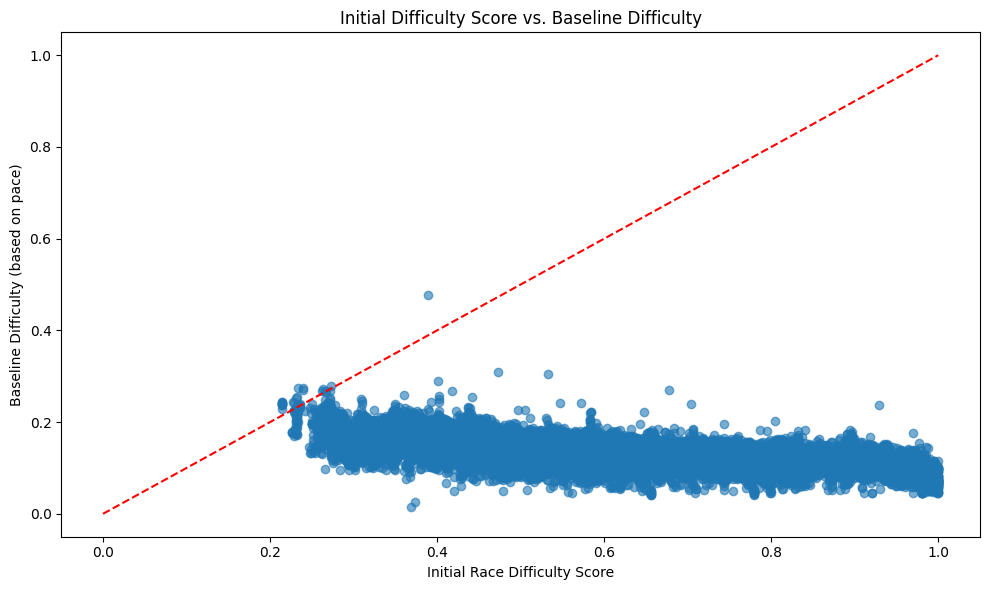

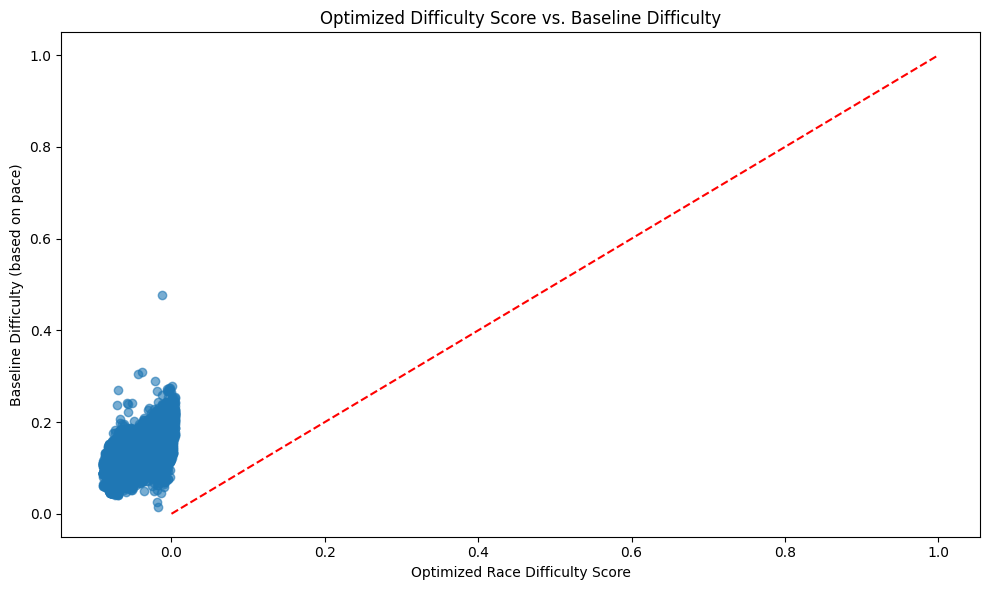

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/2826438032.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=agg_df_filtered['Race Difficulty Score'], shade=True, label='Initial Score')
/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/2826438032.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=agg_df_filtered['Optimized Difficulty Score'], shade=True, label='Optimized Score')


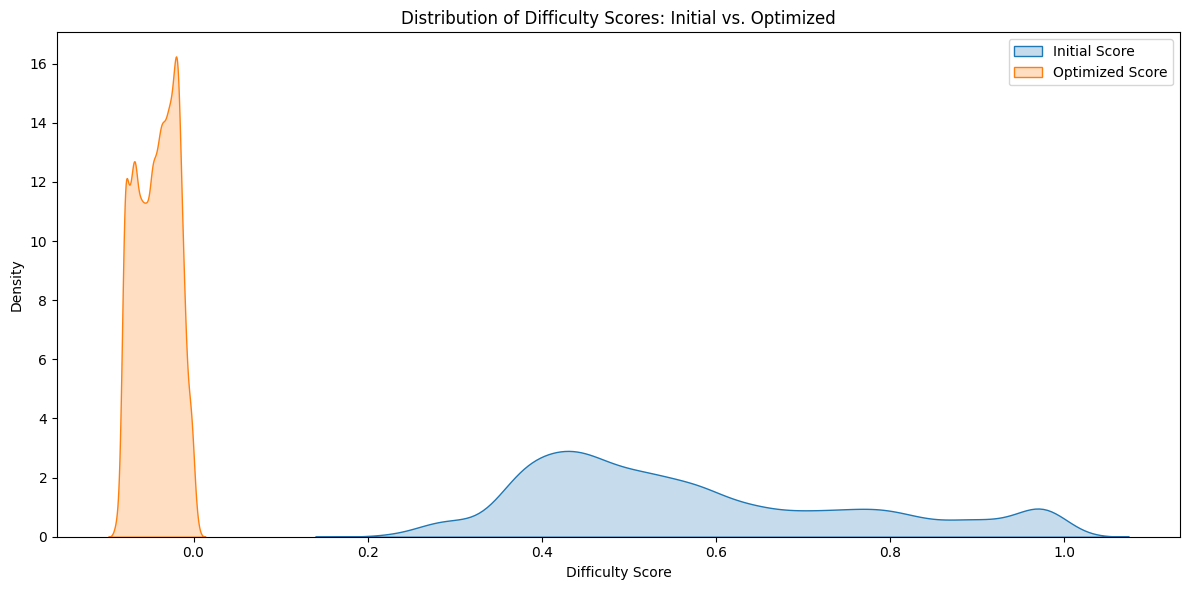

<Figure size 1000x600 with 0 Axes>

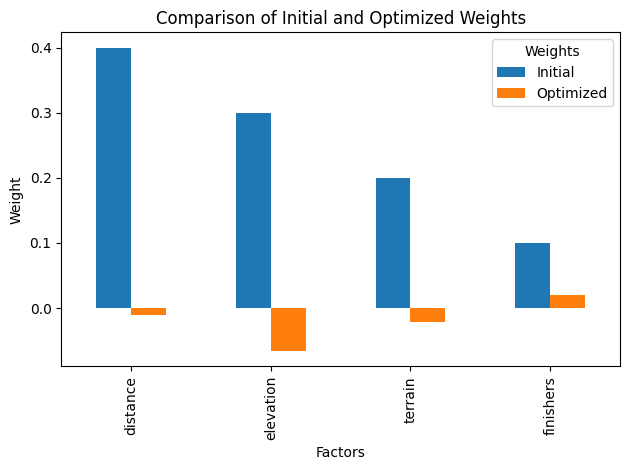

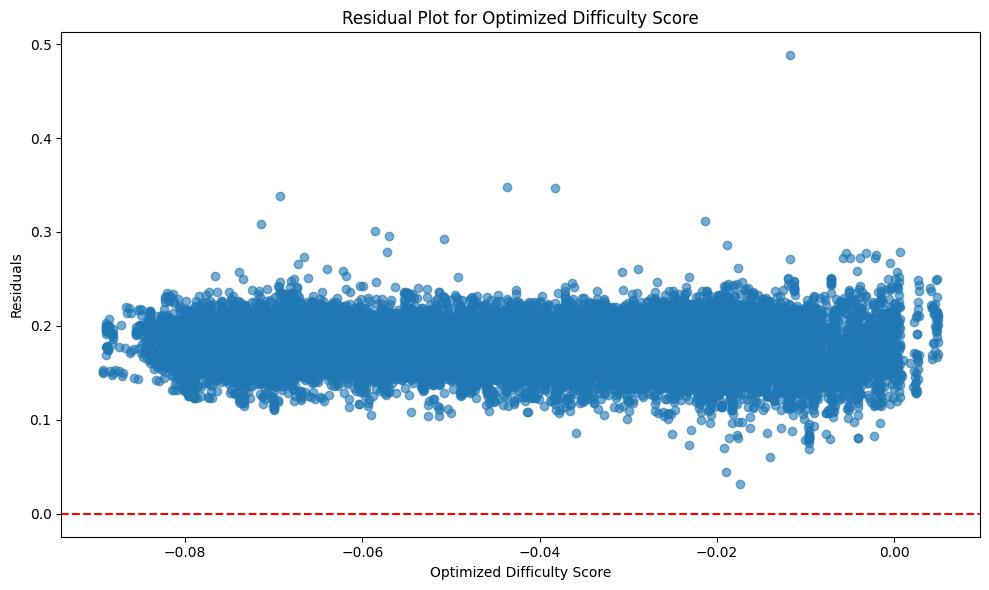

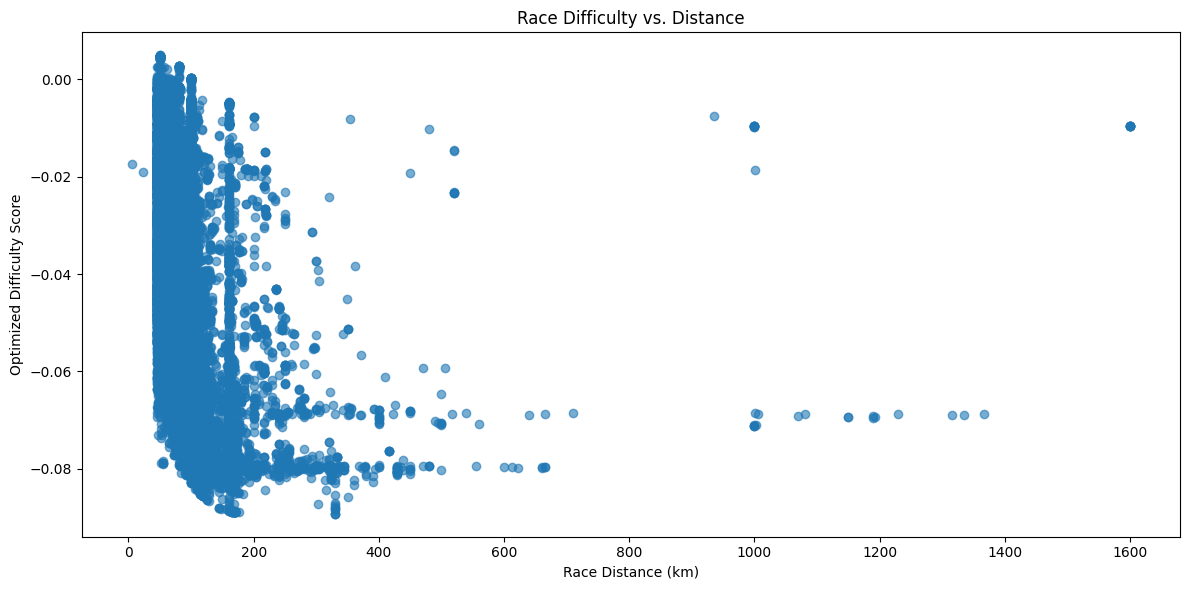

Summary Statistics for Optimized Difficulty Score:
count    25138.000000
mean        -0.042886
std          0.022427
min         -0.089246
25%         -0.062458
50%         -0.041450
75%         -0.023713
max          0.004951
Name: Optimized Difficulty Score, dtype: float64

Correlation Matrix:
                            Distance KM  Elevation Gain  Total Finishers  \
Distance KM                    1.000000        0.478866        -0.089243   
Elevation Gain                 0.478866        1.000000        -0.000372   
Total Finishers               -0.089243       -0.000372         1.000000   
Optimized Difficulty Score    -0.377815       -0.804910        -0.098306   

                            Optimized Difficulty Score  
Distance KM                                  -0.377815  
Elevation Gain                               -0.804910  
Total Finishers                              -0.098306  
Optimized Difficulty Score                    1.000000  


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
#plt.style.use('seaborn')

# 1. Scatter plot of initial difficulty score vs. baseline difficulty
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Race Difficulty Score'], baseline_difficulty, alpha=0.6)
plt.xlabel('Initial Race Difficulty Score')
plt.ylabel('Baseline Difficulty (based on pace)')
plt.title('Initial Difficulty Score vs. Baseline Difficulty')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
plt.tight_layout()
plt.show()

# 2. Scatter plot of optimized difficulty score vs. baseline difficulty
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Optimized Difficulty Score'], baseline_difficulty, alpha=0.6)
plt.xlabel('Optimized Race Difficulty Score')
plt.ylabel('Baseline Difficulty (based on pace)')
plt.title('Optimized Difficulty Score vs. Baseline Difficulty')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
plt.tight_layout()
plt.show()

# 3. Distribution of difficulty scores before and after optimization
plt.figure(figsize=(12, 6))
sns.kdeplot(data=agg_df_filtered['Race Difficulty Score'], shade=True, label='Initial Score')
sns.kdeplot(data=agg_df_filtered['Optimized Difficulty Score'], shade=True, label='Optimized Score')
plt.xlabel('Difficulty Score')
plt.ylabel('Density')
plt.title('Distribution of Difficulty Scores: Initial vs. Optimized')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Bar plot of initial and optimized weights
weights_df = pd.DataFrame({
    'Initial': initial_weights,
    'Optimized': optimized_weights
})

plt.figure(figsize=(10, 6))
weights_df.plot(kind='bar')
plt.title('Comparison of Initial and Optimized Weights')
plt.xlabel('Factors')
plt.ylabel('Weight')
plt.legend(title='Weights')
plt.tight_layout()
plt.show()

# 5. Residual plot for the optimized model
residuals = baseline_difficulty - agg_df_filtered['Optimized Difficulty Score']
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Optimized Difficulty Score'], residuals, alpha=0.6)
plt.xlabel('Optimized Difficulty Score')
plt.ylabel('Residuals')
plt.title('Residual Plot for Optimized Difficulty Score')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# 6. Difficulty score vs. race distance
plt.figure(figsize=(12, 6))
plt.scatter(agg_df_filtered['Distance KM'], agg_df_filtered['Optimized Difficulty Score'], alpha=0.6)
plt.xlabel('Race Distance (km)')
plt.ylabel('Optimized Difficulty Score')
plt.title('Race Difficulty vs. Distance')
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Optimized Difficulty Score:")
print(agg_df_filtered['Optimized Difficulty Score'].describe())

# Print correlation matrix
correlation_matrix = agg_df_filtered[['Distance KM', 'Elevation Gain', 'Total Finishers', 'Optimized Difficulty Score']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

### Random Forest

In [30]:
features = df_clean.groupby('Runner ID').agg(
    average_time=('Time Seconds Finish', 'mean'),
    min_time=('Time Seconds Finish', 'min'),
    max_time=('Time Seconds Finish', 'max'),
    count_races=('Time Seconds Finish', 'count'),
    avg_percentile=('Finish Percentage', 'mean'),
    max_percentile=('Finish Percentage', 'max'),
    min_percentile=('Finish Percentage', 'min'),
    avg_speed=('Average Speed', 'mean'),
    max_speed=('Average Speed', 'max'),
    min_speed=('Average Speed', 'min'),
    race_difficulty=('Race Difficulty Score', 'mean'),
    weighted_performance=('Weighted Performance', 'mean')
).reset_index()

features.head()

,Runner ID,average_time,min_time,max_time,count_races,avg_percentile,max_percentile,min_percentile,avg_speed,max_speed,min_speed,race_difficulty,weighted_performance
0,1,26940.000000,26940.0,26940.0,1,0.840000,0.84,0.84,585.652174,585.652174,585.652174,0.534450,0.279723
1,33,54590.628571,22920.0,631680.0,35,0.668286,0.94,0.38,561.012006,874.555556,469.919355,0.722541,0.480819
2,34,25379.500000,14962.0,35797.0,2,0.435000,0.71,0.16,420.809394,542.378788,299.240000,0.545250,0.363460
3,47,34743.000000,23129.0,46357.0,2,0.260000,0.31,0.21,463.075000,463.570000,462.580000,0.678175,0.531617
4,69,32062.000000,16772.0,45183.0,6,0.525000,0.89,0.38,416.089314,664.455882,335.440000,0.653817,0.433770
